# Rice Classification

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">About Data</p> 

<div style="background-color:#d5eae9; padding:20px; font-size:15px">
    <strong>Dataset</strong> 
    <br>
    
Rice, which is among the most widely produced grain products worldwide, has many genetic varieties. These varieties are separated from each other due to some of their features. These are usually features such as texture, shape, and color. With these features that distinguish rice varieties, it is possible to classify and evaluate the quality of seeds. In this study, Arborio, Basmati, Ipsala, Jasmine and Karacadag, which are five different varieties of rice often grown in Turkey, were used. A total of 75,000 grain images, 15,000 from each of these varieties, are included in the dataset.

In [2]:
# import requirement libraries and tools
import os
import pathlib
import itertools
import splitfolders
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
# To enable dynamic memory allocation, run the following commands 
# at the start of the session :
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
# dataset path
root_path = 'E:\Deep Learning\IMT\CNN\Rice_Image_Dataset'
root_path = pathlib.Path(root_path)

In [5]:
# split train, validation and test set
splitfolders.ratio(input=root_path, output='rice_imgs', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [19:57, 62.62 files/s] 


In [8]:
# Adjust the root path to point to the correct split folder
split_output_path = pathlib.Path('rice_imgs')

Train = keras.utils.image_dataset_from_directory(
    directory=split_output_path.joinpath("train"),
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=42,
)

Validation = keras.utils.image_dataset_from_directory(
    directory=split_output_path.joinpath("val"),
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=42,
)

Test = keras.utils.image_dataset_from_directory(
    directory=split_output_path.joinpath("test"),
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=42,
)


Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


In [8]:
# check class in each set
for i in [Train, Validation, Test]:
    class_names = i.class_names
    print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [9]:
# check shape of train, validation, test
for image_batch, labels_batch in Train:
    print(f"Train Shape: {image_batch.shape} (Bathes = {len(Train)})")
    print(f"Train label: {labels_batch.shape}\n")
    break
for image_batch, labels_batch in Validation:
    print(f"Validation Shape: {image_batch.shape} (Bathes = {len(Validation)})")
    print(f"Validation label: {labels_batch.shape}\n")
    break
for image_batch, labels_batch in Test:
    print(f"Test Shape: {image_batch.shape} (Bathes = {len(Test)})")
    print(f"Test label: {labels_batch.shape}\n")
    break

Train Shape: (16, 150, 150, 3) (Bathes = 3282)
Train label: (16,)

Validation Shape: (16, 150, 150, 3) (Bathes = 704)
Validation label: (16,)

Test Shape: (16, 150, 150, 3) (Bathes = 704)
Test label: (16,)



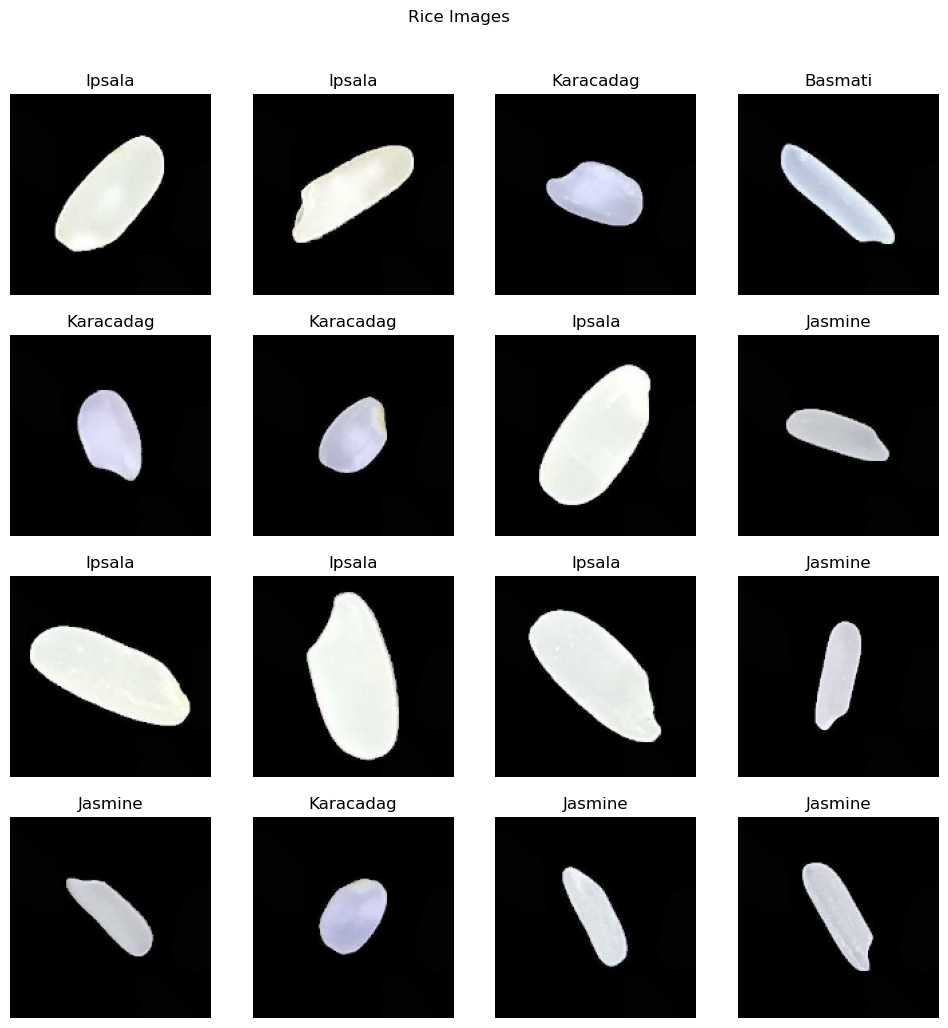

In [10]:
# visualize the data to verify is in the correct format
plt.figure(figsize=(12, 12))
for images, labels in Train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.suptitle('Rice Images', y=0.95)
plt.show()

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model 1</p> 

In [11]:
# Build CNN first Model: 1 conv layer | 1 pool layer | 2 Dense layer | ReLU activation
model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=300, activation='relu'),
        tf.keras.layers.Dense(units=5),
    ]
)

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 300)               52569900  
                                                                 
 dense_1 (Dense)             (None, 5)                 1505      
                                                        

In [12]:
def compile_and_fit(model, optimizer=None, max_epochs=2):
    """
    Compile model and fit model on dataset based on input model until find best epoch
        model: created model
        optimizer: defined optimizer
        max_epochs: Number of epochs
    """
    
    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
    # complie model before train
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # train model
    history = model.fit(
        Train,
        epochs=max_epochs,
        validation_data=Validation,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss' , patience=8),
    )

    return history

In [13]:
# train model_1 and store results
model_hist = compile_and_fit(model_1, max_epochs=20)

Epoch 1/20
3282/3282 [==============================] - 65s 17ms/step - loss: 0.1177 - accuracy: 0.9645 - val_loss: 0.0889 - val_accuracy: 0.9688
Epoch 2/20
3282/3282 [==============================] - 55s 17ms/step - loss: 0.0511 - accuracy: 0.9817 - val_loss: 0.0604 - val_accuracy: 0.9807
Epoch 3/20
3282/3282 [==============================] - 51s 16ms/step - loss: 0.0531 - accuracy: 0.9811 - val_loss: 0.1044 - val_accuracy: 0.9713
Epoch 4/20
3282/3282 [==============================] - 56s 17ms/step - loss: 0.0247 - accuracy: 0.9911 - val_loss: 0.1263 - val_accuracy: 0.9714
Epoch 5/20
3282/3282 [==============================] - 56s 17ms/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.1641 - val_accuracy: 0.9717
Epoch 6/20
3282/3282 [==============================] - 56s 17ms/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.1766 - val_accuracy: 0.9706
Epoch 7/20
3282/3282 [==============================] - 52s 16ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.2216 -

In [14]:
def plot_comparision_result(model):
    """
    Plot diagram of accuracy and loss for train and validation set
        model: created model
    """
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot train and validation accuracy
    axs[0].plot(model.history['accuracy'], color="red", marker="o")
    axs[0].plot(model.history['val_accuracy'], color="blue", marker="h")
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")
    
    # Plot train and validation loss
    axs[1].plot(model.history['loss'], color="red", marker="o")
    axs[1].plot(model.history['val_loss'], color="blue", marker="h")
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
# -----------------------------------------------------------------

def get_ture_and_pred_labels(dataset, model):
    """
    Get out 2 list include y_true and y_pred for use in confusion_matrix
        dataset: dataset include images and label
        model: created model
    """
    
    y_true = []
    y_pred = []
    
    for images, labels in dataset:
        labels = labels.numpy()
        outputs = tf.nn.softmax(model(images))
        pred = tf.argmax(outputs, axis=1).numpy()
        images = images.numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


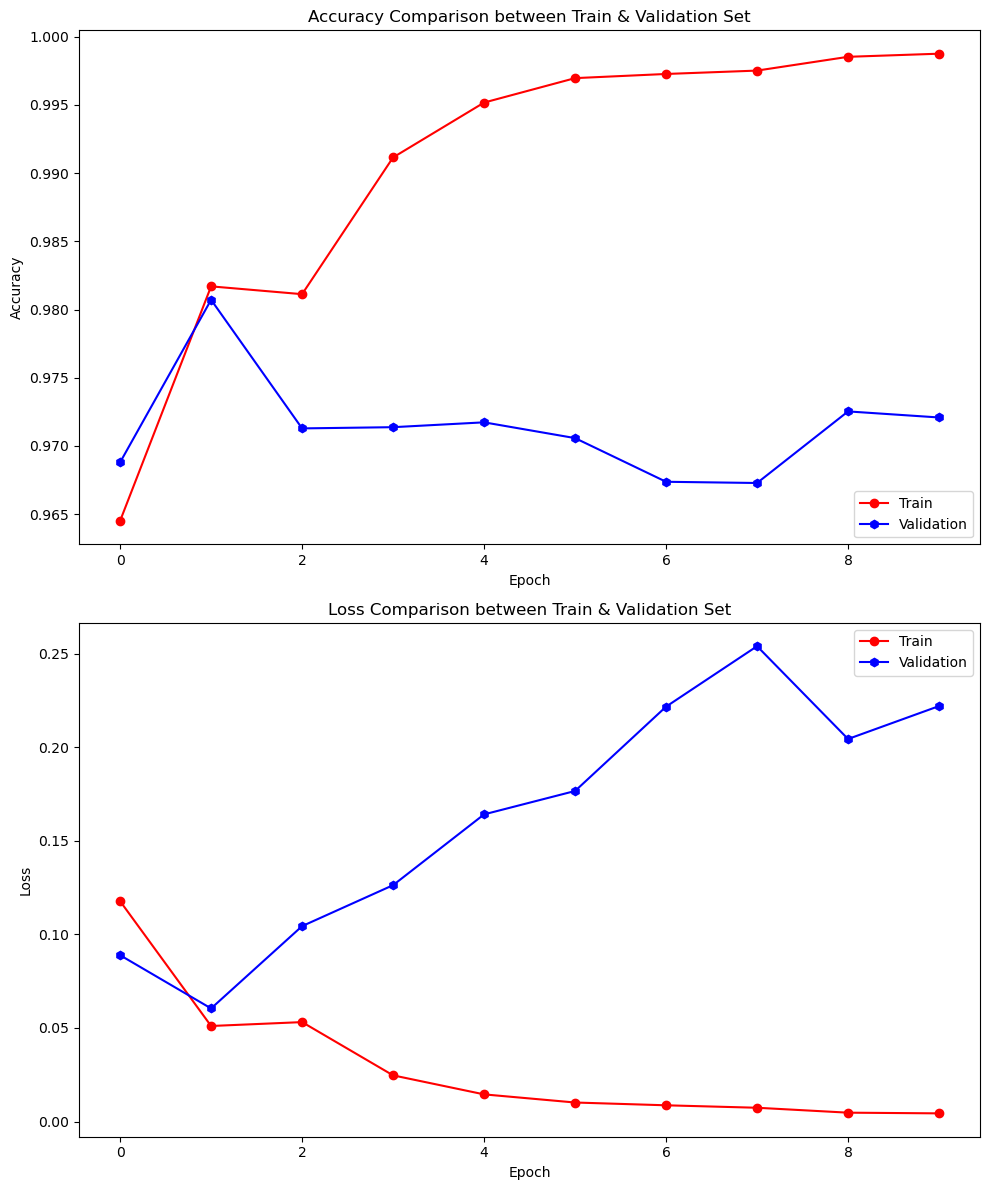

In [15]:
plot_comparision_result(model_hist)

#### As can be seen in the plots above, the values of validation acc are lower than train acc, so the model is overfitting

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model 2</p> 

In [24]:
# Build CNN second Model: add dropout layer, regularization-L2 and other Dense layer with 100 units
model_2 = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=300, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(units=100, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=5),
    ]
)

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 175232)            0         
                                                                 
 dense_6 (Dense)             (None, 300)               52569900  
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                      

In [25]:
# complie and train model_2
model_hist = compile_and_fit(model_2, max_epochs=20)

Epoch 1/20
3282/3282 [==============================] - 61s 18ms/step - loss: 0.4186 - accuracy: 0.9265 - val_loss: 0.2416 - val_accuracy: 0.9683
Epoch 2/20
3282/3282 [==============================] - 58s 18ms/step - loss: 0.2134 - accuracy: 0.9651 - val_loss: 0.1623 - val_accuracy: 0.9748
Epoch 3/20
3282/3282 [==============================] - 58s 18ms/step - loss: 0.1589 - accuracy: 0.9741 - val_loss: 0.1437 - val_accuracy: 0.9731
Epoch 4/20
3282/3282 [==============================] - 59s 18ms/step - loss: 0.1431 - accuracy: 0.9770 - val_loss: 0.1556 - val_accuracy: 0.9696
Epoch 5/20
3282/3282 [==============================] - 59s 18ms/step - loss: 0.1293 - accuracy: 0.9790 - val_loss: 0.1235 - val_accuracy: 0.9777
Epoch 6/20
3282/3282 [==============================] - 59s 18ms/step - loss: 0.1207 - accuracy: 0.9812 - val_loss: 0.1097 - val_accuracy: 0.9836
Epoch 7/20
3282/3282 [==============================] - 62s 19ms/step - loss: 0.1164 - accuracy: 0.9819 - val_loss: 0.1322 -

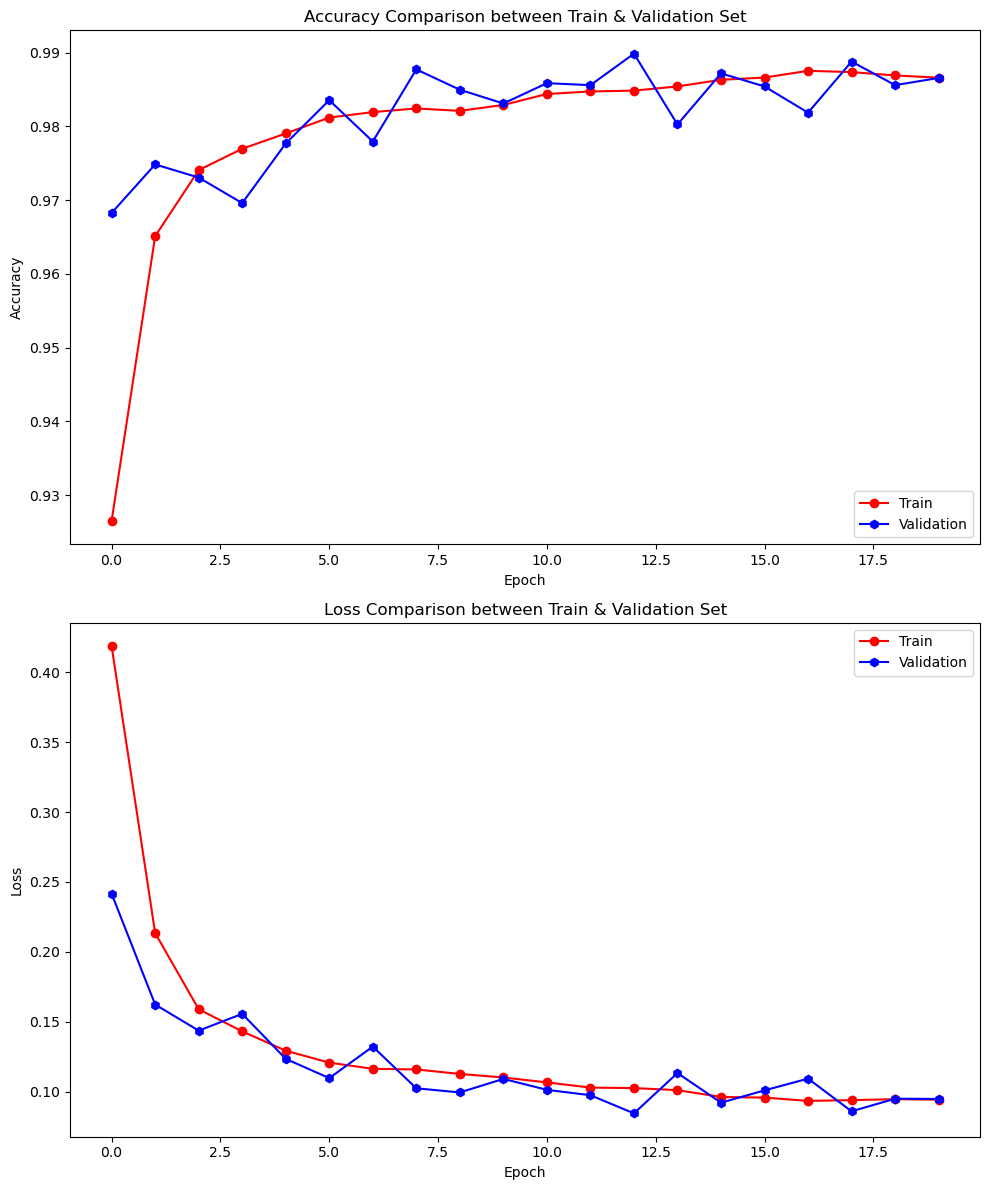

In [26]:
# show result of model_2
plot_comparision_result(model_hist)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2250
         1.0       0.97      0.99      0.98      2250
         2.0       1.00      1.00      1.00      2250
         3.0       0.98      0.97      0.98      2250
         4.0       0.99      0.99      0.99      2250

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250
 




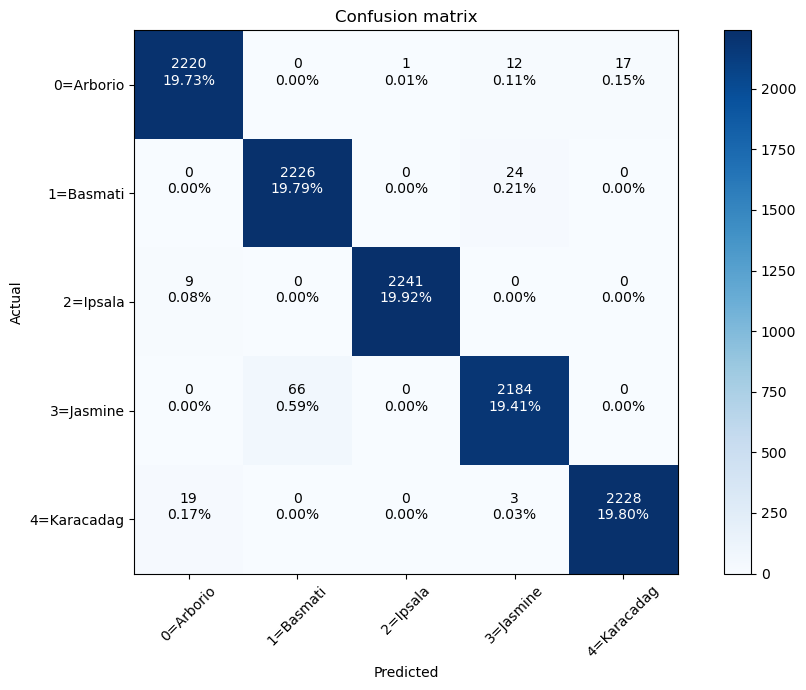

In [27]:
# plot confusion matrix for error analysis
y_true_val, y_pred_val = get_ture_and_pred_labels(Validation, model_2)

print(classification_report(y_true_val, y_pred_val), '\n\n')
cm = confusion_matrix(y_true_val, y_pred_val)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [37]:
# Save the entire model to a HDF5 file.
model_2.save('my_model.h5')

In [38]:
# select best model
# Recreate the exact same model, including its weights and the optimizer
final_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
final_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 175232)            0         
                                                                 
 dense_6 (Dense)             (None, 300)               52569900  
                                                                 
 dense_7 (Dense)             (None, 100)               30100     
                                                      

<a class="anchor" id="About_Data"></a>
# <p style="padding:10px;background-color:#d5eae9;margin:0;color:#c27849;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Evaluate The Final Model</p> 

In [41]:
for images, labels in Test:
    test_labels = labels
    predictions = tf.nn.softmax(final_model(images))
    test_images = images
    break

In [42]:
# check prediction
print(f"Predicted Logits for First Image: {predictions[0]}")
print(f"Predicted Label for First Image: {np.argmax(predictions[0])}")

Predicted Logits for First Image: [5.3931308e-05 2.6566139e-01 2.9089097e-05 7.3425174e-01 3.8142873e-06]
Predicted Label for First Image: 3


In [43]:
def plot_image(i, predictions_array, true_label, img):
    """
    For plot each image
        i (int): image number
        predictions_array (tensor): prediction for input_image
        ture_label (tensor): true label for input_image
        img (tensor): input_image
    """

    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"))
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

# -------------------------------------------------------------

def plot_value_array(i, predictions_array, true_label):
    """
    Plot bar plot of predciton
        i (int): image number
        predictions_array (tensor): prediction array of image
        ture_label (tensor): true label for image
    """

    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# -----------------------------------------------------------------------------    
    
def plot_final_result(predictions_array, test_labels, test_images, num_rows=10, num_cols=3):
    """
    Plot the first X test images, their predicted labels, and the true labels.
        predictions_array(): all predictions for all test_image
        test_labels(): all true label for all test_image
        test_images(): all test_image
    """
    
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions_array[i], test_labels, test_images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions_array[i], test_labels)
        
    plt.tight_layout()
    plt.show()

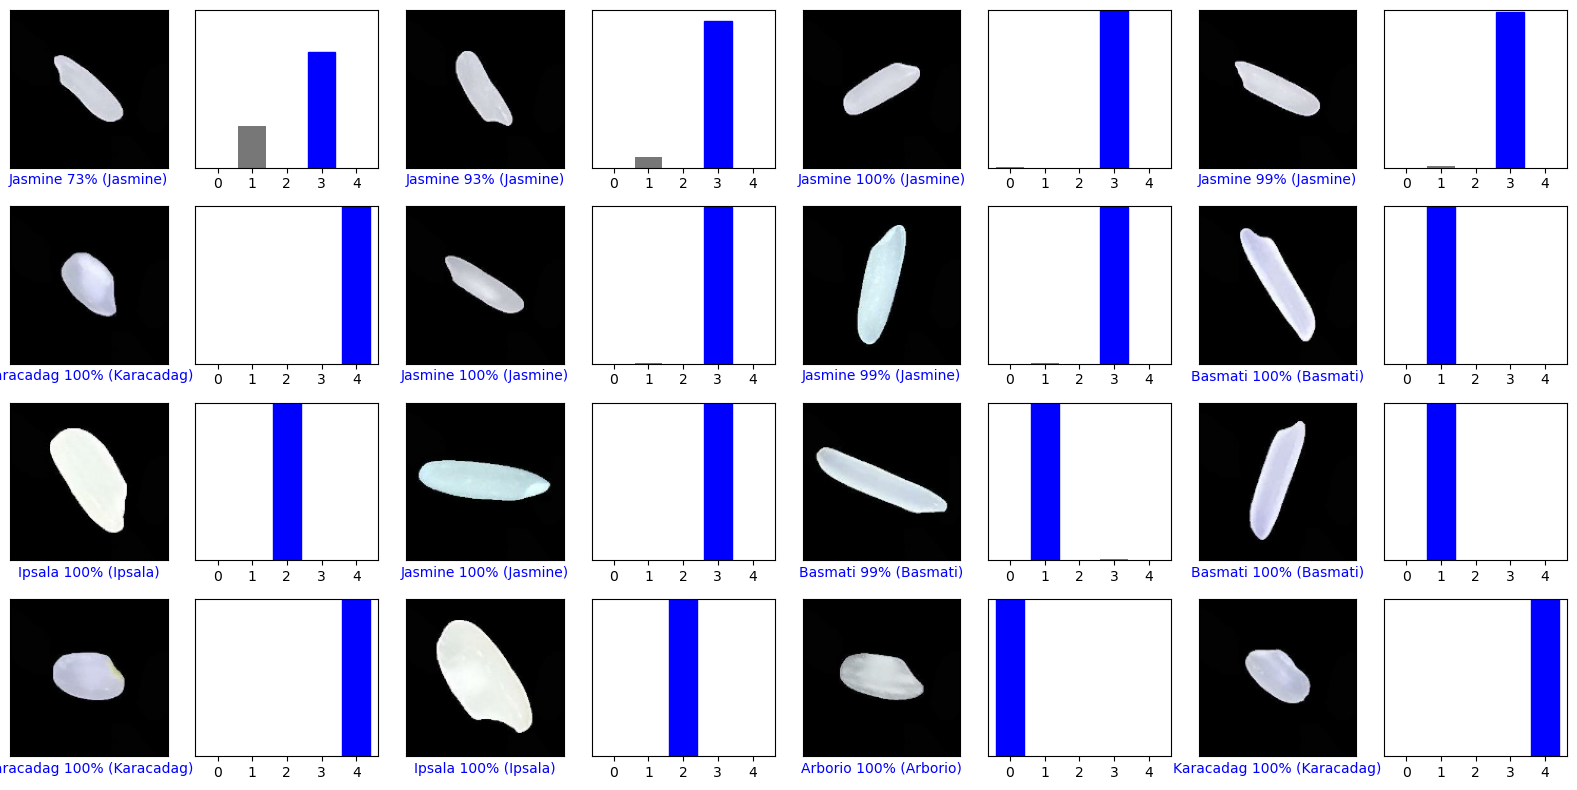

In [44]:
plot_final_result(predictions, test_labels, test_images, num_rows=4, num_cols=4)